In [2]:
from IPython.display import display
from ipywidgets import *
import pandas as pd
import math
import scipy.optimize as opt
import matplotlib.pyplot as plt
import numpy as np

def circleArea(do,di=0):
    return (math.pi/4) * (do**2-di**2)

def cylinderVolume(h,do,di=0):
    return circleArea(do,di) * h

Dc=15
Lc=25.4
Vc=cylinderVolume(Lc,Dc)

Vc

4488.5505038164165

In [28]:
Do=15
do=3.175
Lo=25.4
N=1

Lgo=N*Lo
Vg=cylinderVolume(Lo,Do,do)

Vg

4287.450973049597

In [4]:
Vl=Vg/Vc
Vl

0.9551972222222223

In [5]:
ei=1
ci=1
osi=0
Abeo=N*2*(math.pi/4)*(Do**2 - do**2)
Abeo

337.59456480705495

In [6]:
Abco=N*ci*math.pi*do*Lo
Abco

253.35373954874885

In [7]:
Abso=N*osi*math.pi*do*Lo
Abso

0.0

In [8]:
Abo=Abeo+Abco+Abso
Abo

590.9483043558038

In [9]:
KnMax = 254

# find Tweb end point
def Tweb(x):
    return ((Do-osi*2*x)-(do+2*x))/2

x_twebMin=opt.newton(Tweb,0)

In [10]:
# f(x) = ((Lgo-2*N*x) - (2*x+do))/2
def AbTot(x):
    dCol=2*x+do
    eCol=Tweb(x)
    fCol=Lgo-2*N*x
    gCol=(eCol-dCol)/2
    hCol=2*circleArea(Do,dCol)
    kCol=math.pi*dCol*fCol
    return hCol+kCol

AbMax = -opt.minimize_scalar(lambda x: -AbTot(x), bounds=[0,x_twebMin], method='bounded').fun
Ato = AbMax/KnMax
print("Ato:" + str(Ato))

Dto=math.sqrt(4*Ato/math.pi)
print("Dto:" + str(Dto))

Ato:3.074659878021123
Dto:1.978579930987648


<IPython.core.display.Javascript object>


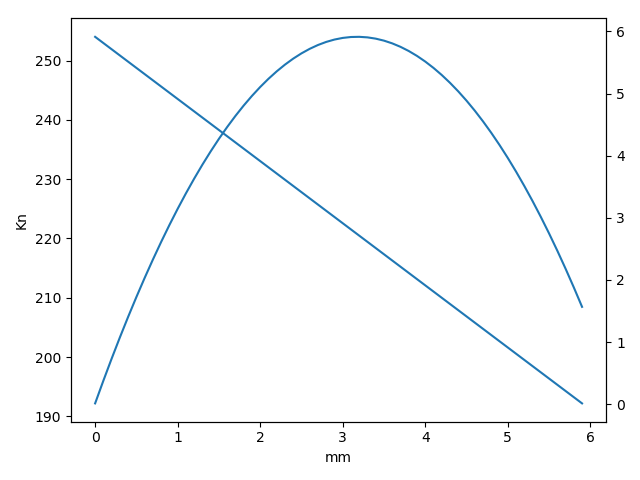

In [30]:
%matplotlib notebook
x = np.arange(0., x_twebMin, .1)
Ab_series = AbTot(x)
Kn_series = Ab_series / Ato
Tweb_series = Tweb(x)

fig, pltKn,  = plt.subplots()
pltKn.plot(x, Kn_series)

pltKn.set_xlabel('mm')
pltKn.set_ylabel('Kn')
pltTweb = pltKn.twinx()
pltTweb.plot(x, Tweb_series)
pltTweb.set_label('Tweb (mm)')

fig.tight_layout()

plt.show()